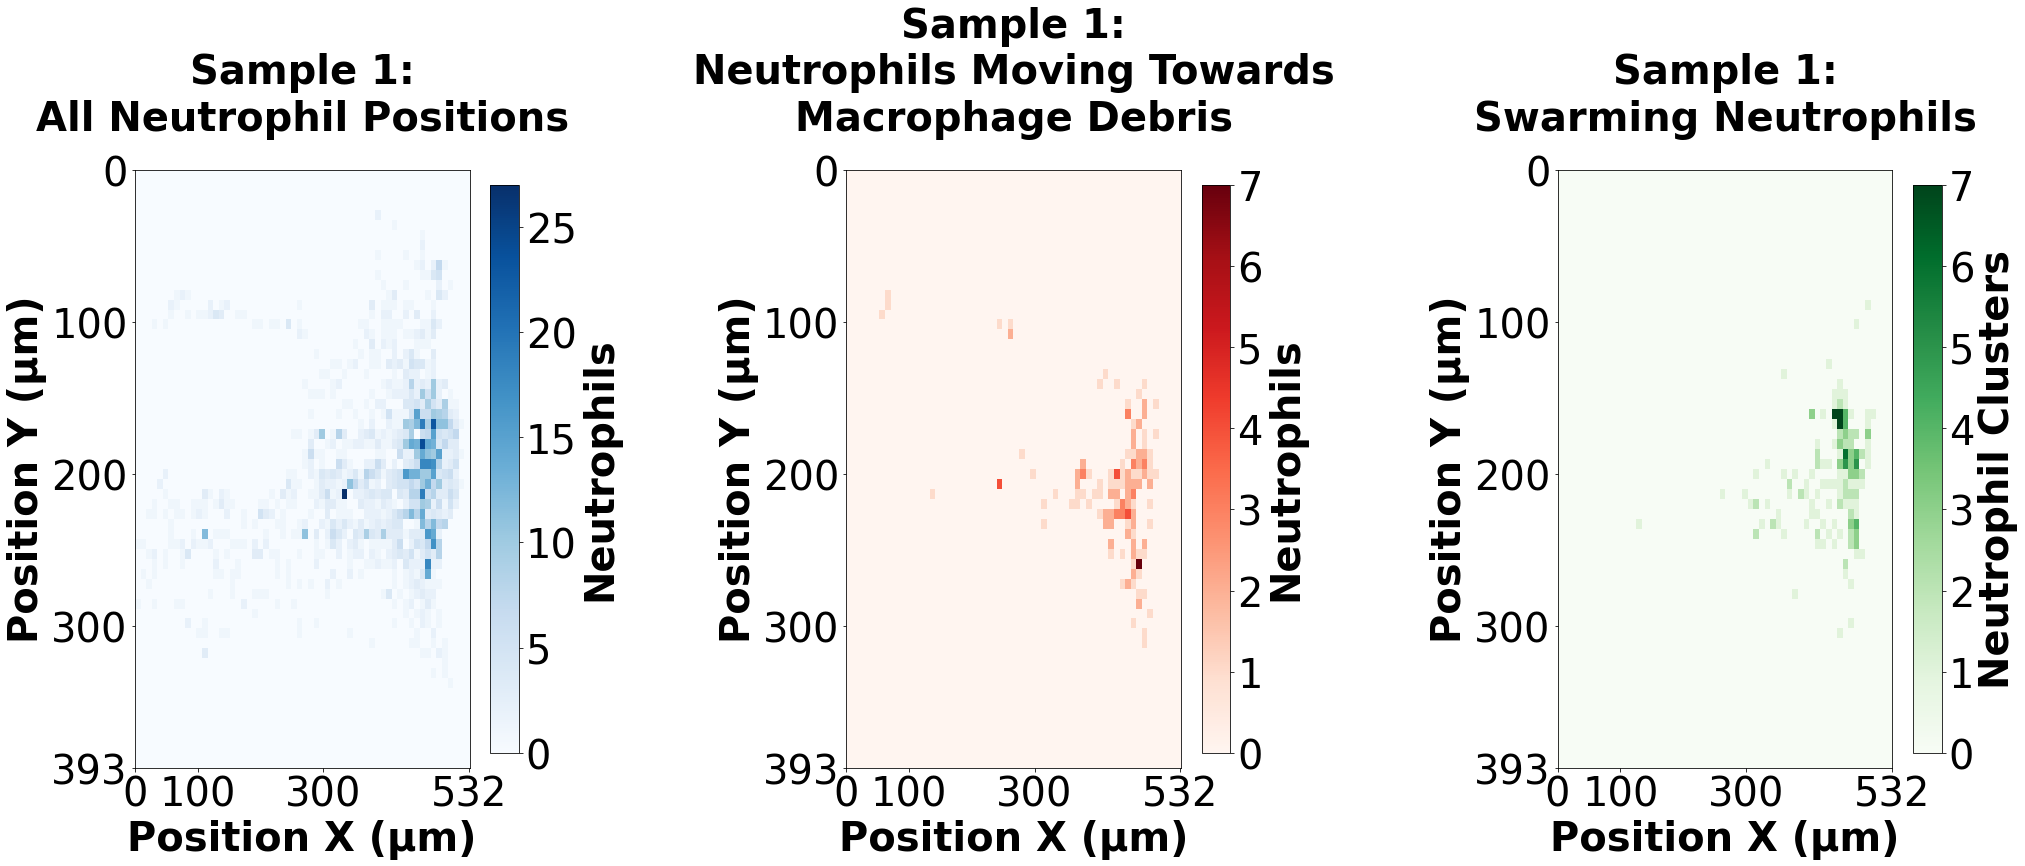

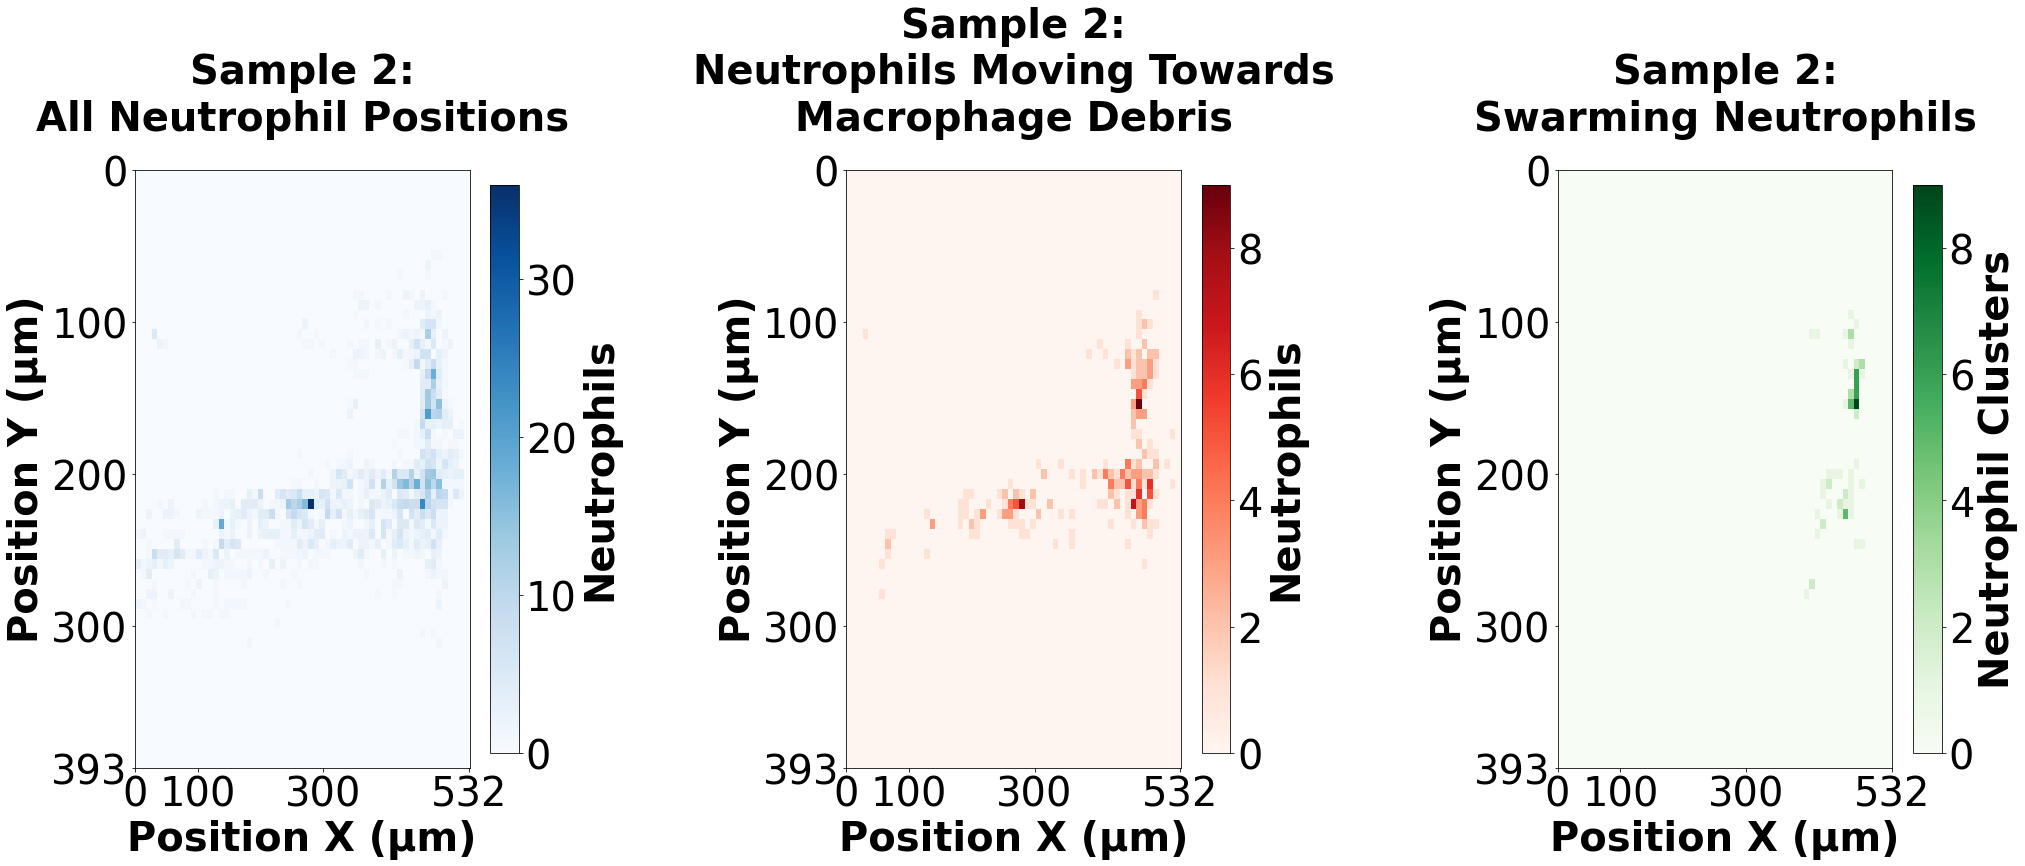

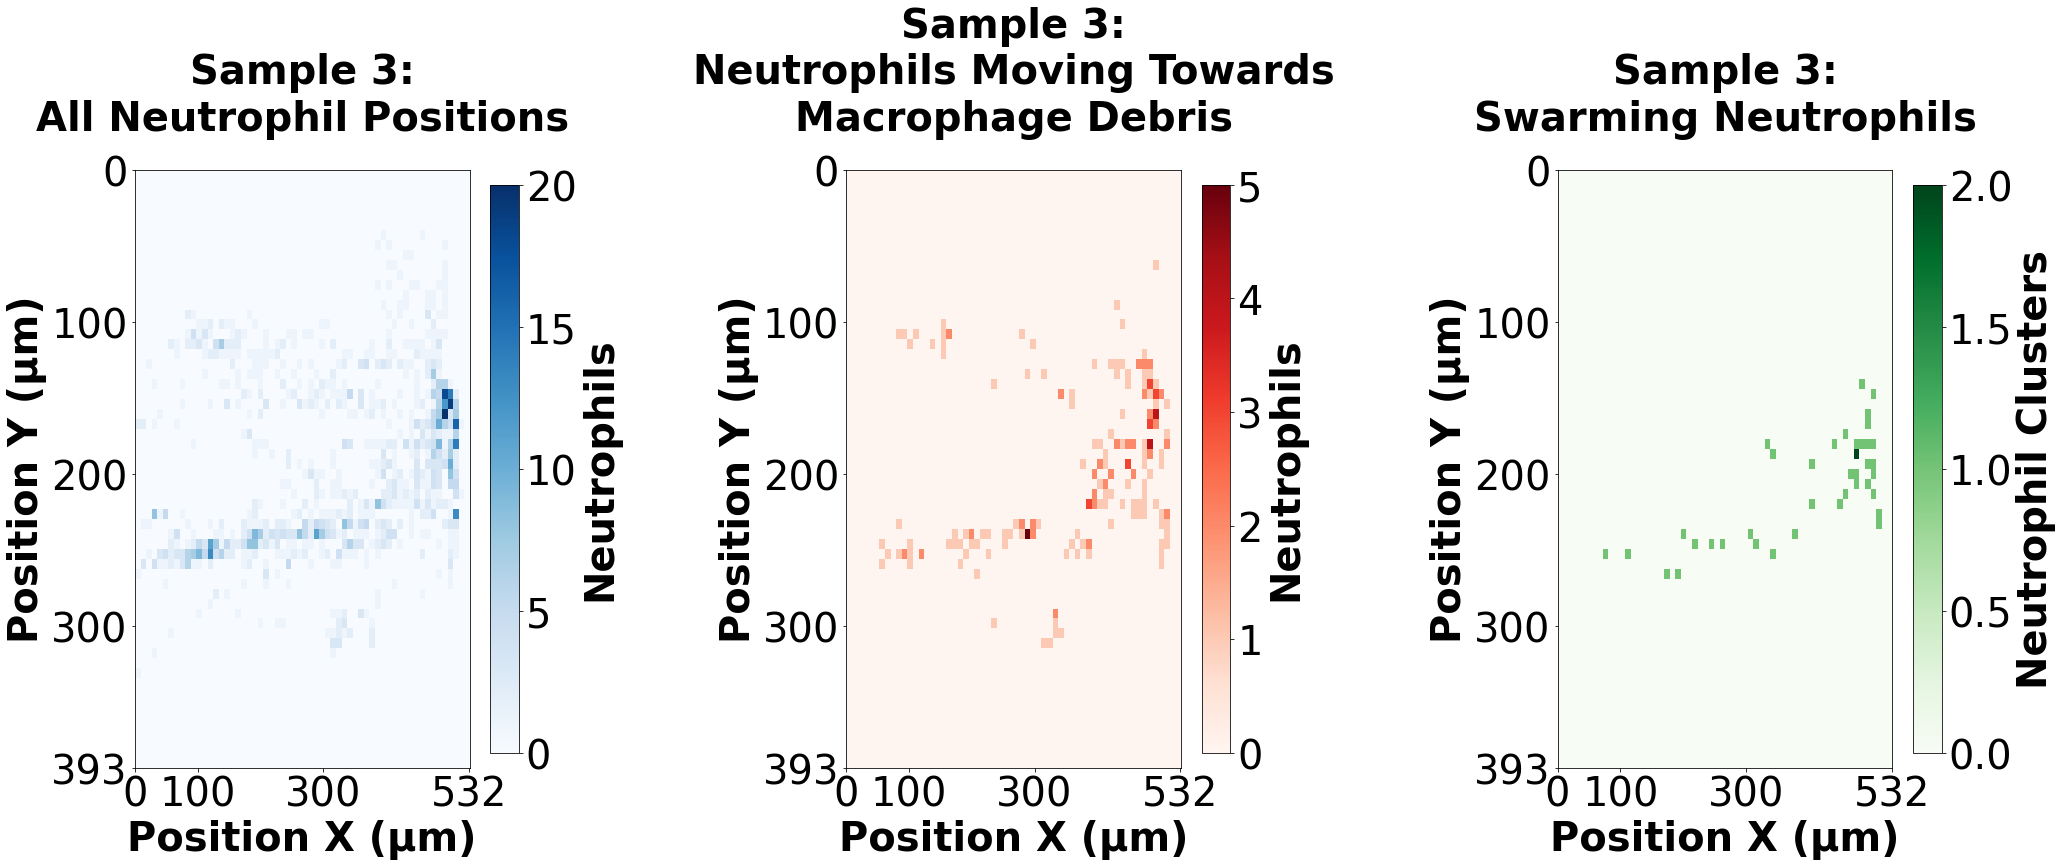

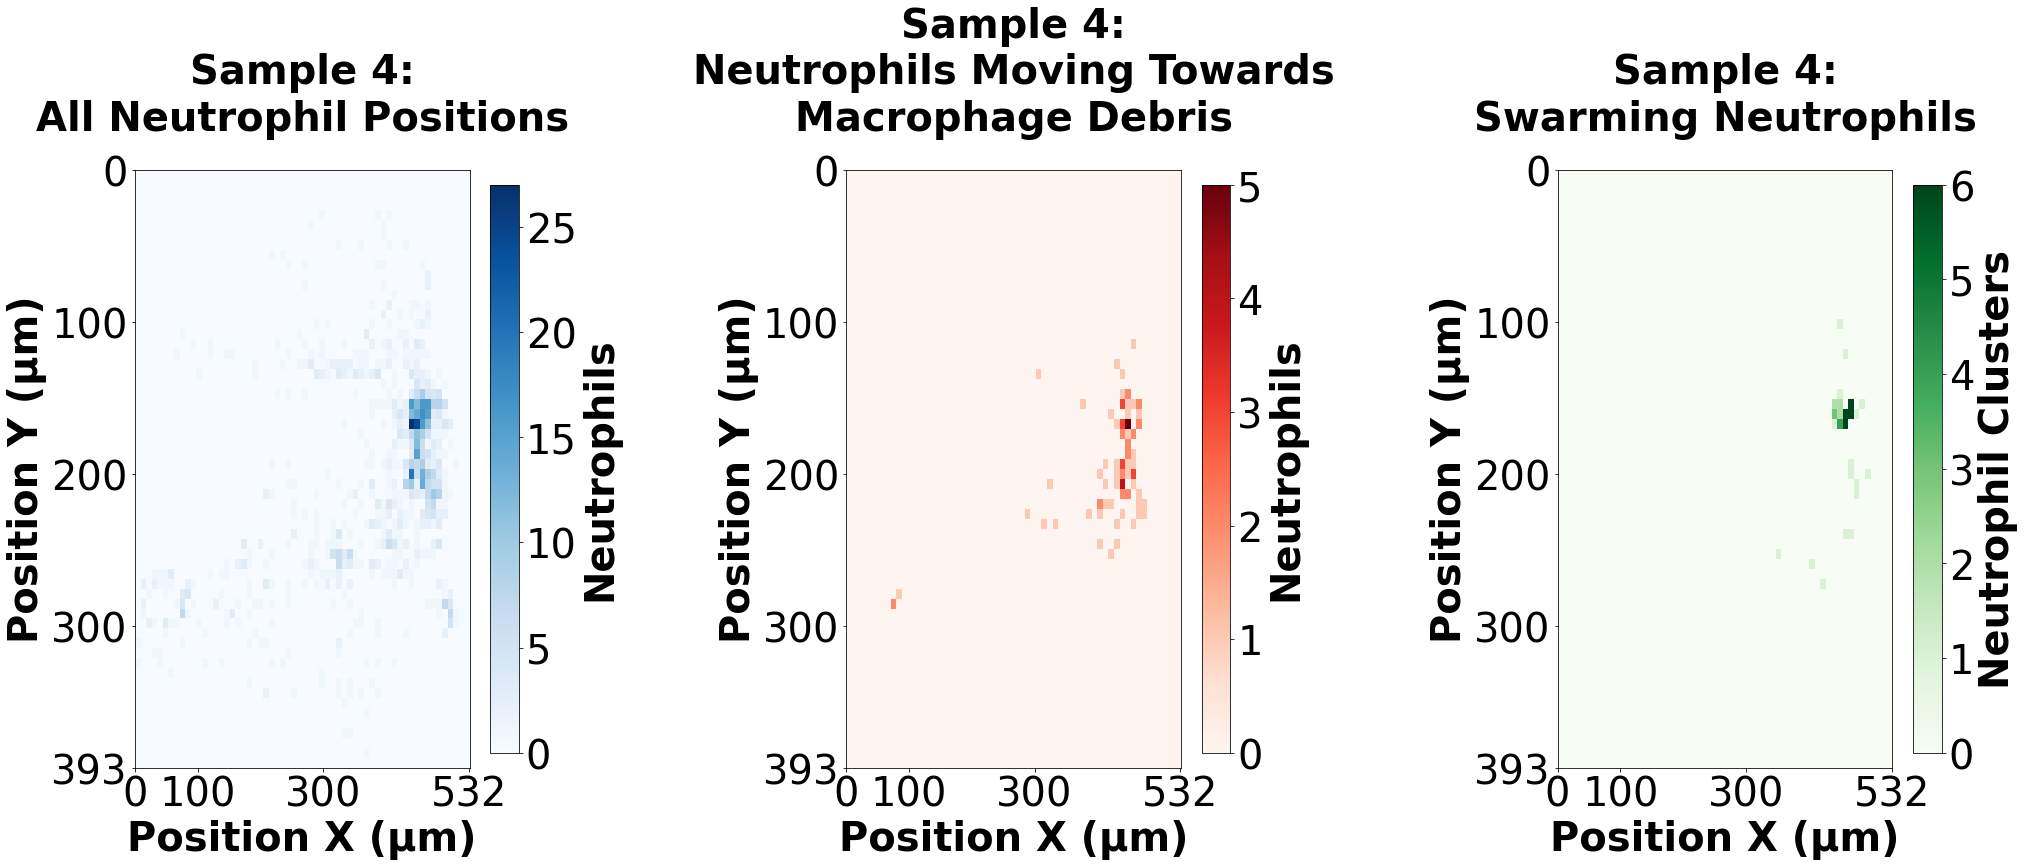

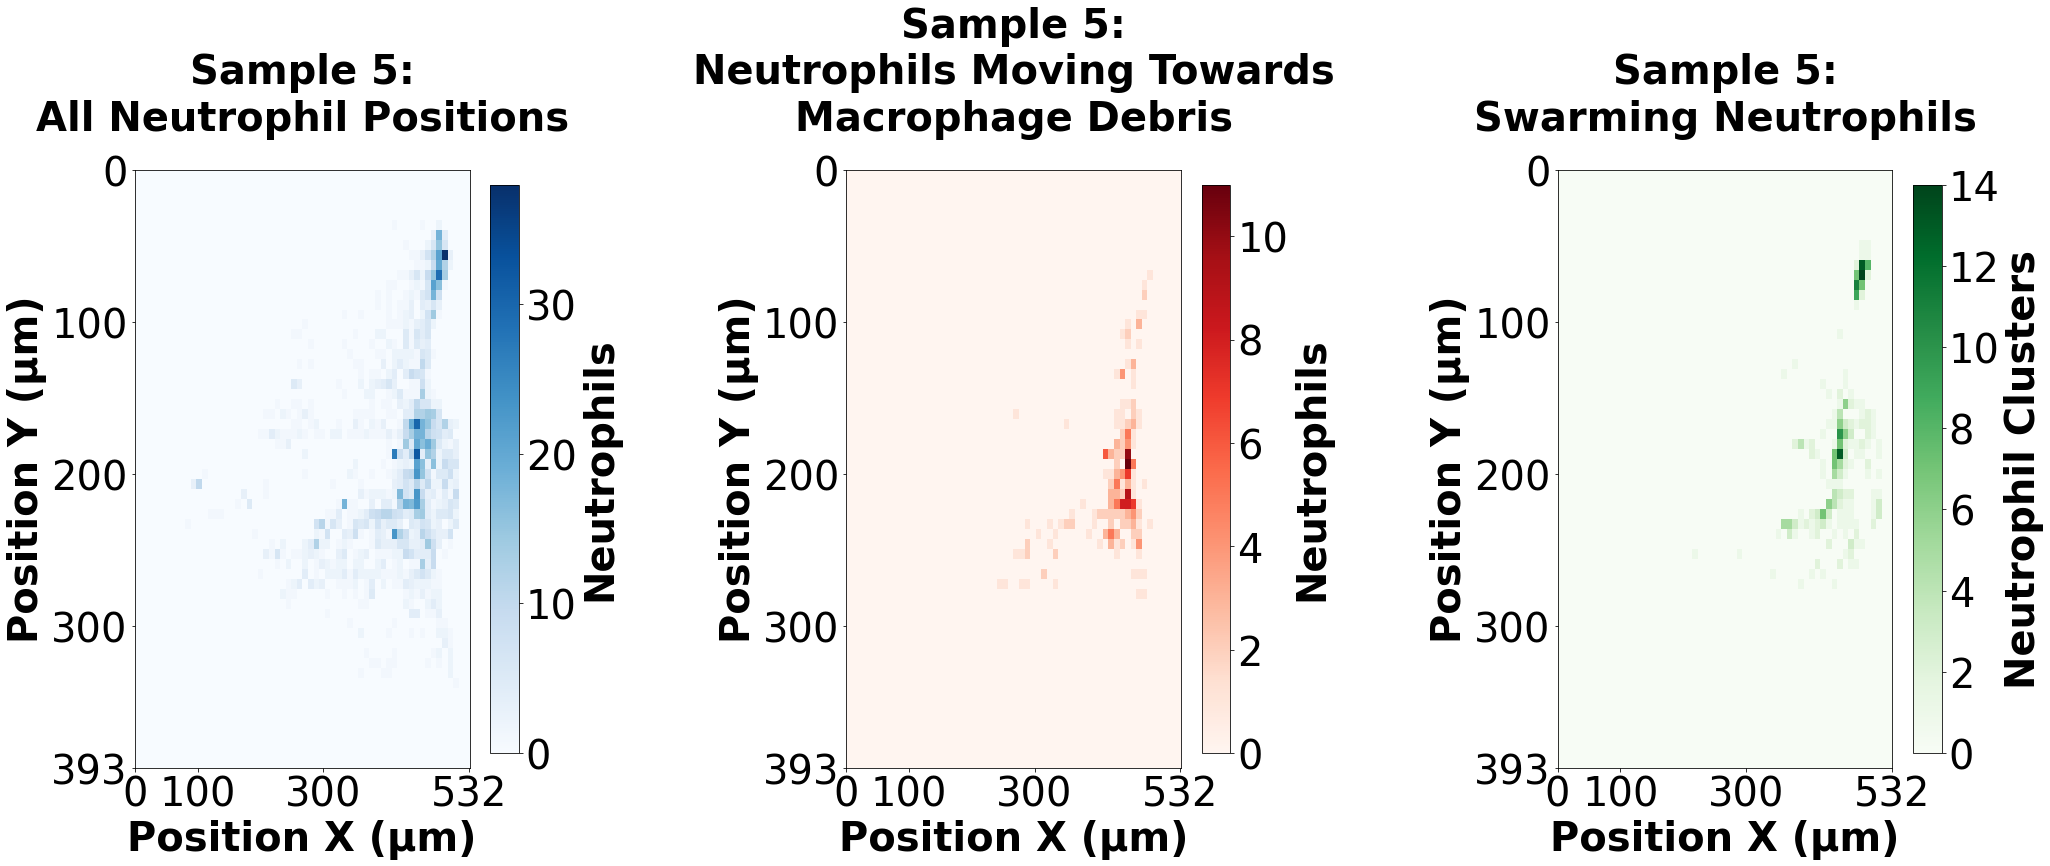

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

# List of macrophage and neutrophil files for each sample change folder location accordingly
samples = [
    {'macrophage_debris_file': 'C://Users//Macrophage_Debris_Sample1.csv', 'neutrophil_file': 'C://Users//Neutrophil_Spots_Sample1.csv', 'swarming_file': 'C://Users//Swarming_Sample1.csv'},
    {'macrophage_debris_file': 'C://Users//Macrophage_Debris_Sample2.csv', 'neutrophil_file': 'C://Users//Neutrophil_Spots_Sample2.csv', 'swarming_file': 'C://Users//Swarming_Sample2.csv'},
    {'macrophage_debris_file': 'C://Users//Macrophage_Debris_Sample3.csv', 'neutrophil_file': 'C://Users//Neutrophil_Spots_Sample3.csv', 'swarming_file': 'C://Users//Swarming_Sample3.csv'},
    {'macrophage_debris_file': 'C://Users//Macrophage_Debris_Sample4.csv', 'neutrophil_file': 'C://Users//Neutrophil_Spots_Sample4.csv', 'swarming_file': 'C://Users//Swarming_Sample4.csv'},
    {'macrophage_debris_file': 'C://Users//Macrophage_Debris_Sample5.csv', 'neutrophil_file': 'C://Users//Neutrophil_Spots_Sample5.csv', 'swarming_file': 'C://Users//Swarming_Sample5.csv'}
]

# Function to load data
def load_data(macrophage_debris_file, neutrophil_file, swarming_file):
    data_macrophage_debris = pd.read_csv(macrophage_debris_file)
    data_neutrophils = pd.read_csv(neutrophil_file)
    data_swarming = pd.read_csv(swarming_file)
    return data_macrophage_debris, data_neutrophils, data_swarming

# Calculate movements towards macrophage debris with additional filtering
def calculate_movement_towards_macrophage_debris(data_macrophage_debris, data_neutrophils, min_distance=20, min_movement=1):
    aligned_positions = pd.merge(data_macrophage_debris, data_neutrophils, on='FRAME', suffixes=('_mac', '_neu'))
    aligned_positions['distance'] = np.sqrt((aligned_positions['POSITION_X_mac'] - aligned_positions['POSITION_X_neu'])**2 + (aligned_positions['POSITION_Y_mac'] - aligned_positions['POSITION_Y_neu'])**2)
    
    # Filter by distance
    aligned_positions = aligned_positions[aligned_positions['distance'] <= min_distance]
    
    aligned_positions['neu_dir_x'] = aligned_positions.groupby('TRACK_ID_neu')['POSITION_X_neu'].diff()
    aligned_positions['neu_dir_y'] = aligned_positions.groupby('TRACK_ID_neu')['POSITION_Y_neu'].diff()
    
    # Calculate movement magnitude and filter by minimum movement
    aligned_positions['movement_magnitude'] = np.sqrt(aligned_positions['neu_dir_x']**2 + aligned_positions['neu_dir_y']**2)
    aligned_positions = aligned_positions[aligned_positions['movement_magnitude'] >= min_movement]
    
    aligned_positions['mac_vec_x'] = aligned_positions['POSITION_X_mac'] - aligned_positions['POSITION_X_neu']
    aligned_positions['mac_vec_y'] = aligned_positions['POSITION_Y_mac'] - aligned_positions['POSITION_Y_neu']
    
    # Calculate dot product
    aligned_positions['dot_product'] = aligned_positions['neu_dir_x'] * aligned_positions['mac_vec_x'] + aligned_positions['neu_dir_y'] * aligned_positions['mac_vec_y']
    
    # Normalize dot product by movement magnitude
    aligned_positions['normalized_dot_product'] = aligned_positions['dot_product'] / aligned_positions['movement_magnitude']
    
    return aligned_positions[aligned_positions['normalized_dot_product'] > -0]

# Function to calculate colocalization with swarming neutrophils
def calculate_colocalization_with_swarms(movement_towards_macrophage_debris, data_swarming, radius=10):
    colocalized = []
    for idx, row in movement_towards_macrophage_debris.iterrows():
        # Filter swarming data to the current frame
        swarming_in_frame = data_swarming[data_swarming['FRAME'] == row['FRAME']]
        distances = np.sqrt((swarming_in_frame['XM um'] - row['POSITION_X_neu'])**2 + (swarming_in_frame['YM um'] - row['POSITION_Y_neu'])**2)
        if any(distances <= radius):
            colocalized.append(True)
        else:
            colocalized.append(False)
    movement_towards_macrophage_debris['colocalized_with_swarms'] = colocalized
    return movement_towards_macrophage_debris

# Get global min and max values for binning
all_positions_neutrophils = []
all_positions_swarming = []
for sample in samples:
    _, data_neutrophils, data_swarming = load_data(sample['macrophage_debris_file'], sample['neutrophil_file'], sample['swarming_file'])
    all_positions_neutrophils.append(data_neutrophils[['POSITION_X', 'POSITION_Y']])
    all_positions_swarming.append(data_swarming[['XM um', 'YM um']])

all_positions_neutrophils = pd.concat(all_positions_neutrophils)
all_positions_swarming = pd.concat(all_positions_swarming)

# Define global extents for all plots
x_limits = [0, 533]  
y_limits = [0, 393]

# Define consistent bins
bins_x = np.linspace(x_limits[0], x_limits[1], 61)
bins_y = np.linspace(y_limits[0], y_limits[1], 61)

# Create folder for colocalisation CSVs
output_folder = 'C://Users//Admin//Desktop//PhD_Data//Thesis//Chapter4//Analysis//231031_Montpellier//colocalisation'
os.makedirs(output_folder, exist_ok=True)

# Plot heatmaps for each sample
for i, sample in enumerate(samples, start=1):
    # Load data for the sample
    data_macrophage_debris, data_neutrophils, data_swarming = load_data(sample['macrophage_debris_file'], sample['neutrophil_file'], sample['swarming_file'])
    
    # Calculate movements towards macrophages
    movement_towards_macrophage_debris = calculate_movement_towards_macrophage_debris(data_macrophage_debris, data_neutrophils)
    
    # Calculate colocalization with swarming neutrophils
    movement_towards_macrophage_debris = calculate_colocalization_with_swarms(movement_towards_macrophage_debris, data_swarming)
    
    # Calculate percentage colocalisation
    total_neutrophils = len(data_neutrophils)
    moving_towards_macrophages = len(movement_towards_macrophage_debris)
    colocalized_with_swarms = movement_towards_macrophage_debris['colocalized_with_swarms'].sum()
    
    percentage_towards_macrophages = (moving_towards_macrophages / total_neutrophils) * 100 if total_neutrophils > 0 else 0
    percentage_colocalized_with_swarms = (colocalized_with_swarms / moving_towards_macrophages) * 100 if moving_towards_macrophages > 0 else 0
    
    # Save percentages to CSV
    colocalisation_data = pd.DataFrame({
        'Sample': [f'Sample {i}'],
        'Percentage_Towards_Macrophage_Debris': [percentage_towards_macrophages],
        'Percentage_Colocalized_With_Swarms': [percentage_colocalized_with_swarms]
    })
    colocalisation_data.to_csv(os.path.join(output_folder, f'colocalisation_sample_{i}.csv'), index=False)
    
    # Create heatmaps side by side for the sample
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    
    # Adjust space between plots
    plt.subplots_adjust(wspace=0.7)
    
    # Heatmap of all neutrophils
    heatmap_all, _, _ = np.histogram2d(data_neutrophils['POSITION_X'], data_neutrophils['POSITION_Y'], bins=[bins_x, bins_y])
    im1 = axes[0].imshow(heatmap_all.T, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], origin='lower', cmap='Blues', aspect='auto')
    axes[0].set_title(f'Sample {i}:\nAll Neutrophil Positions', fontsize=40, fontweight='bold', pad=40)
    axes[0].set_xlabel('Position X (µm)', fontsize=40, fontweight='bold')
    axes[0].set_ylabel('Position Y (µm)', fontsize=40, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(False)
    cbar1 = fig.colorbar(im1, ax=axes[0], shrink=0.95)
    cbar1.set_label('Neutrophils', fontsize=40, fontweight='bold')
    cbar1.ax.tick_params(labelsize=40)
    axes[0].tick_params(axis='both', which='major', labelsize=40)
    
    # Ensure ticks at the extremities
    axes[0].set_xticks([0, 100, 300, 532])
    axes[0].set_yticks([0, 100, 200, 300, 393])
    
    # Heatmap of neutrophils moving towards macrophages
    heatmap_towards, _, _ = np.histogram2d(movement_towards_macrophage_debris['POSITION_X_neu'], movement_towards_macrophage_debris['POSITION_Y_neu'], bins=[bins_x, bins_y])
    im2 = axes[1].imshow(heatmap_towards.T, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], origin='lower', cmap='Reds', aspect='auto')
    axes[1].set_title(f'Sample {i}:\nNeutrophils Moving Towards\nMacrophage Debris', fontsize=40, fontweight='bold', pad=40)
    axes[1].set_xlabel('Position X (µm)', fontsize=40, fontweight='bold')
    axes[1].set_ylabel('Position Y (µm)', fontsize=40, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(False)
    cbar2 = fig.colorbar(im2, ax=axes[1], shrink=0.95)
    cbar2.set_label('Neutrophils', fontsize=40, fontweight='bold')
    cbar2.ax.tick_params(labelsize=40)
    axes[1].tick_params(axis='both', which='major', labelsize=40)
    
    # Ensure ticks at the extremities
    axes[1].set_xticks([0, 100, 300, 532])
    axes[1].set_yticks([0, 100, 200, 300, 393])
    
    # Heatmap of swarming neutrophils
    heatmap_swarming, _, _ = np.histogram2d(data_swarming['XM um'], data_swarming['YM um'], bins=[bins_x, bins_y])
    im3 = axes[2].imshow(heatmap_swarming.T, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], origin='lower', cmap='Greens', aspect='auto')
    axes[2].set_title(f'Sample {i}:\nSwarming Neutrophils', fontsize=40, fontweight='bold', pad=40)
    axes[2].set_xlabel('Position X (µm)', fontsize=40, fontweight='bold')
    axes[2].set_ylabel('Position Y (µm)', fontsize=40, fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(False)
    cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.95)
    cbar3.set_label('Neutrophil Clusters', fontsize=40, fontweight='bold')
    cbar3.ax.tick_params(labelsize=40)
    axes[2].tick_params(axis='both', which='major', labelsize=40)
    
    # Ensure ticks at the extremities
    axes[2].set_xticks([0, 100, 300, 532])
    axes[2].set_yticks([0, 100, 200, 300, 393])
    
    plt.show()
